# Table of HPF observations
## Needed for the paper


Author: Michael Gully-Santiago  
Date: Nov 21, 2022

Let's make a table of HPF observations

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

### Read in the table of metadata

In [3]:
def get_metadata_from_fits(filenames, dynamic_only=True):
    df_out = pd.DataFrame()
    for file in tqdm(filenames):
        hdu = fits.open(file)
        hdr = hdu[0].header
        
        # Remove duplicate keys like `HISTORY`
        columns = np.array(list(hdr.keys()))
        _, indices, counts = np.unique(columns, return_index=True, return_counts=True)
        columns = columns[np.isin(columns, columns[indices[counts==1]])]
        df = pd.Series({col:hdr[col] for col in columns }).to_frame().T
        df['file']=file
        df_out = df_out.append(df, ignore_index=True)
        hdu.close()
    
    # Only keep columns that change in time
    if dynamic_only:
        dynamic_columns = df_out.apply(lambda x: len(pd.unique(x))) != 1
        df_out = df_out[dynamic_columns[dynamic_columns].index.values]
        
    return df_out

In [4]:
tacc_path = '/Volumes/pecos/HPF/TACC'

In [5]:
exosphere_program_ids = ['UT19-2-013', 'UT19-3-009',  'UT20-1-012', 
                         'UT20-2-011', 'UT20-3-009', 'UT21-1-010', 'UT22-2-019']

In [6]:
tacc_goldilocks_files = []
for prog_id in exosphere_program_ids:
    print(prog_id)
    pattern = tacc_path + '/{}/*spectra.fits'.format(prog_id)
    filenames = glob.glob(pattern, recursive=True)
    tacc_goldilocks_files += filenames

UT19-2-013
UT19-3-009
UT20-1-012
UT20-2-011
UT20-3-009
UT21-1-010
UT22-2-019


In [7]:
len(tacc_goldilocks_files)

1073

In [8]:
%%capture
df_raw = get_metadata_from_fits(tacc_goldilocks_files)

In [9]:
len(df_raw)

1073

In [10]:
df_raw['full_path'] = tacc_goldilocks_files

In [11]:
target_mask = df_raw.OBJECT.str.contains('67')
df = df_raw[target_mask]

In [12]:
df.OBJECT.value_counts()

HAT-P-67b_IN_1             28
HAT-P-67b_IN_2             14
hat-p-67b                  12
HAT-P-67b_IN_3              9
HAT-P-67b_OUT_same3         9
HAT-P-67b_OUT_1_before1     4
HAT-P-67b_OUT_3_after2      4
HAT-P-67b_OUT_2_b2          4
HAT-P-67b_OUT_1_a2          4
HAT-P-67b_OUT_1_a1          4
HAT-P-67b_OUT_1_b1          4
Hat-P-67                    4
HAT-P-67b_OUT_1_b2          4
HAT-P-67b_OUT_3_after1      4
HAT-P-67b_OUT_2_after2      4
HAT-P-67b_OUT_2_after1      4
HAT-P-67b_OUT_2_before1     4
HAT-P-67b_OUT_2_before2     4
HAT-P-67b_OUT_1_after1      4
HAT-P-67b_OUT_3_before1     4
HAT-P-67b_EPOCH2            3
HAT-P-67b_EPOCH5            3
HAT-P-67b_EPOCH3            3
HAT-P-67b_EPOCH4            3
HAT-P-67b_EPOCH1            3
HAT-P-67b_OUT_3_before2     3
HAT-P-67b_P1_monitor_4      2
HAT-P-67b_P1_monitor_5      2
HAT-P-67b_P1_monitor_8      2
HAT-P-67b_P1_monitor_1      1
HAT-P-67b_P1_monitor_2      1
HAT-P-67b_P1_monitor_6      1
Name: OBJECT, dtype: int64

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [13]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

In [14]:
df['JD'] = df['DATE-OBS'].apply(lambda x: Time(x).jd)
df['BTJD'] = df.JD -2457000.0

df['phase'] = np.mod(df.BTJD-t_c_btjd+(orbital_period*0.5),orbital_period)-0.5*orbital_period
df['normalized_phase']=(df['phase']/orbital_period)
df['in_transit_flag']=np.abs(df['normalized_phase']) < t_14_orb_phase/2.0

In [15]:
def get_full_path(fn, trimester, base_path=None):
    """Get the full path to the data synced from TACC
    
    Parameters:
    ----------
    
    fn (str): The Goldilocks or PSU reduced 1D filename
    trimester (str): The trimester identifier "QPROG" from the FITS header
    base_path: The root directory to the TACC-synced data
    """
    
    return str(base_path) + '/' + str(trimester) + '/' + str(fn)

In [16]:
#df['full_path'] = df.apply(lambda x: get_full_path(x.file_basename_Goldilocks, x.QPROG, base_path=base_path), axis=1)

Assign the "campaigns" surrounding individual transits.

In [17]:
from astropy.time import Time
import astropy.units as u

In [18]:
hpf_t0 = Time(['2017-11-29T17:00:00.0']) # 17h UTC is ~noon in Fort Davis
JD_values = df['JD'].values
night_number = np.floor(JD_values - hpf_t0.jd).astype(int)
time_from_local_midnight = np.round(np.mod(JD_values - hpf_t0.jd, 1)*24.0 - 12.0, decimals=2)
df.insert(0, 'night_number', night_number)
nightly_timestamp = (hpf_t0 + df.night_number*u.day).iso
df.insert(1, 'night_of', [string[0:10] for string in nightly_timestamp])
df.insert(2, 'local_hour', time_from_local_midnight) # Negative means time until local midnight

In [19]:
df.night_of.value_counts().sort_index()

2020-04-26     4
2020-04-27    14
2020-04-28     4
2020-05-19     4
2020-05-20     4
2020-05-21    14
2020-05-22     4
2020-05-23     4
2020-06-12     3
2020-06-13     4
2020-06-14    18
2020-06-15     4
2020-06-17     4
2020-07-21     2
2020-07-31     2
2021-01-30     2
2021-01-31     2
2021-02-23     2
2021-02-25     2
2021-03-03     2
2021-03-30     2
2022-04-26     4
2022-04-27     4
2022-04-28    14
2022-04-29     4
2022-04-30     4
2022-05-01     4
2022-06-19     3
2022-06-21     6
2022-06-22     3
2022-06-25     1
2022-06-30     1
2022-07-09     1
2022-07-10     1
2022-07-12     3
2022-07-14     1
2022-07-15     1
2022-07-19     1
2022-07-28     1
2022-07-29     1
Name: night_of, dtype: int64

In [20]:
df['campaign'] = ''

df.campaign[df.night_of.isin(['2020-04-26', '2020-04-27', '2020-04-28'])] = 'April 2020'
df.campaign[df.night_of.str.contains('2020-05')] = 'May 2020'
df.campaign[df.night_of.str.contains('2020-06')] = 'June 2020'
df.campaign[df.night_of.isin(['2022-04-26', '2022-04-27', '2022-04-28', 
                              '2022-04-29', '2022-04-30', '2022-05-01'])] = 'April 2022'
df.campaign[df.campaign==''] = 'P4'

## Conduct Helium analysis

Derive median uncertainty

In [21]:
df.campaign.value_counts()

P4            40
April 2022    34
June 2020     33
May 2020      30
April 2020    22
Name: campaign, dtype: int64

In [22]:
df = df.reset_index(drop=True)

In [23]:
threshold = 0.035 # SNR per pixel should be better than ~30:1

In [24]:
df['stddev_order19'] = 0.0
for i, fn in enumerate(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec = spec_raw.sky_subtract(method='vector').remove_nans().trim_edges().deblaze().normalize()
    spec = spec.apply_boolean_mask(spec.wavelength<(10827*u.Angstrom)).remove_nans().trim_edges()
    df.loc[i, 'stddev_order19'] = np.nanstd(spec.flux.value)

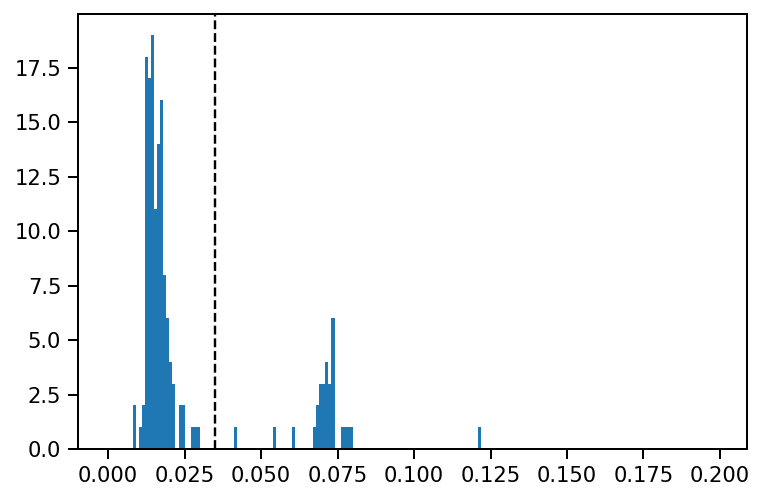

In [25]:
plt.hist(df.stddev_order19, bins=np.arange(0, 0.2, 0.001));
plt.axvline(threshold, linestyle='dashed', color='k')

In [26]:
high_snr = df.stddev_order19 < threshold

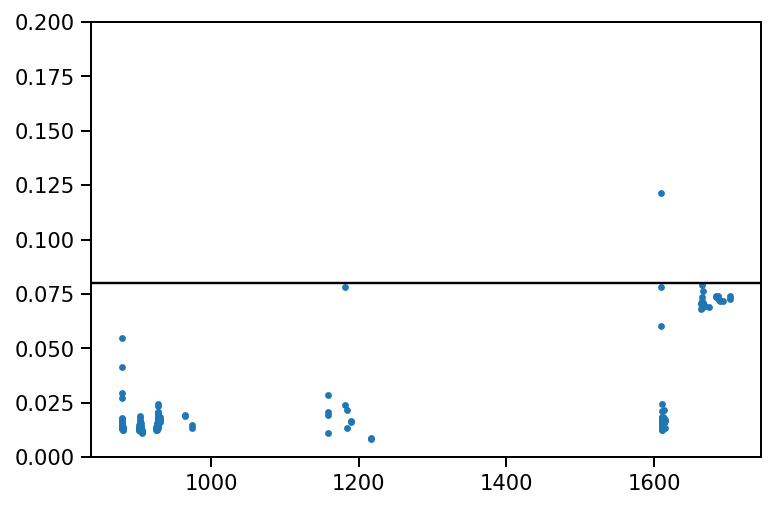

In [27]:
plt.plot(df.night_number, df.stddev_order19, '.')
plt.ylim(0, 0.2)
plt.axhline(0.08, color='k')
#plt.xlim(1300)

In [28]:
fn1 = '/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_20220502T063058_v1.0_0033.spectra.fits'
fn2 = '/Volumes/pecos/HPF/TACC/UT22-2-019/Goldilocks_20220622T031918_v1.0_0002.spectra.fits'

(0.6, 0.95)

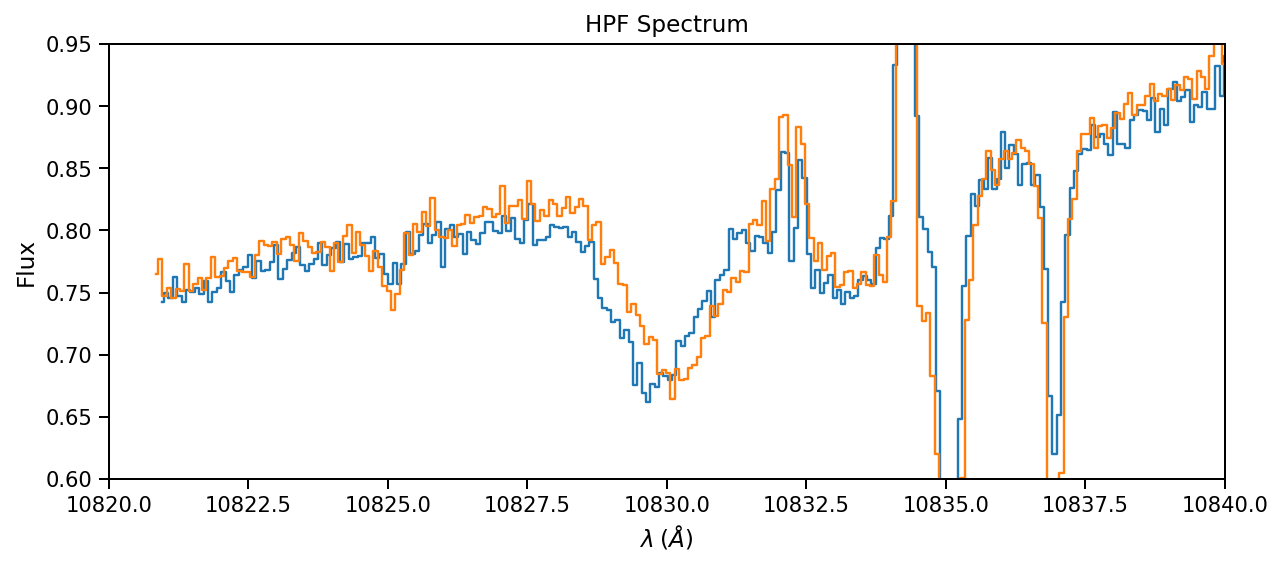

In [29]:
spec_raw = HPFSpectrum(file=fn1, order=19)
ax = spec_raw.normalize().trim_edges().plot()
spec_raw2 = HPFSpectrum(file=fn2, order=19)
spec_raw2.normalize().trim_edges().plot(ax=ax)
ax.set_xlim(10820, 10840)
ax.set_ylim(0.6, 0.95)

For some reason the summer 2022 have a shift?  Keep them all...

In [30]:
summer_2022 = (df.night_of.str.contains('2022-05') | 
               df.night_of.str.contains('2022-06') | 
               df.night_of.str.contains('2022-07') )

In [31]:
df = df[high_snr | summer_2022].reset_index(drop=True)

In [32]:
df.columns.values

array(['night_number', 'night_of', 'local_hour', 'ORIGIN', 'DATE',
       'OBJECT', 'OBSERVER', 'OBSTYPE', 'DATE-OBS', 'CAL-OBJ', 'QTIME',
       'QRA', 'QDEC', 'QEQUINOX', 'QEPOCH', 'QPMRA', 'QPMDEC', 'QPROG',
       'QIDX', 'TRAJTIME', 'TRAJID', 'RADETIME', 'RA', 'DEC', 'RA_2000',
       'DEC_2000', 'HA', 'LST', 'PA', 'EL', 'AZ', 'ZA', 'TTIME', 'RTFX',
       'RTFY', 'RTFZ', 'RTFRHO', 'RTFTHETA', 'RTFPHI', 'STRTTIME',
       'STRTTGT', 'STRTAZ', 'STRTEL', 'DOMETIME', 'DOMETGT', 'DOMEPOS',
       'ENVTIME', 'ENVTEM', 'ENVHUM', 'ENVPRE', 'ENVWIN', 'ENVDIR',
       'ENVSTD', 'ENVTMIR', 'ENVTTRU', 'PFSHTIME', 'PFSHPOS', 'FCUTIME',
       'FCULAMPA', 'FCULAMPB', 'FCULBPOS', 'FCULGPOS', 'FCULAMP',
       'LS218_1', 'LS218_2', 'LS218_3', 'LS218_4', 'LS218_5', 'LS218_6',
       'LS218_7', 'TMCRCX10', 'TMCTCX10', 'TMCV2N00', 'TMCT2N00',
       'TMCPHT10', 'TMCRCX11', 'TMCTCX11', 'TMCV2N01', 'TMCT2N01',
       'TMCPHT11', 'TMCRCX12', 'TMCTCX12', 'TMCV2N02', 'TMCT2N02',
       'TMCPHT12', 'TMCR

In [33]:
df.groupby('night_of')[['ITIME', 'normalized_phase', 'QRA', 'HA', 'stddev_order19']]\
    .aggregate(func={'ITIME':np.mean, 'normalized_phase':np.mean,'stddev_order19':np.max,  
                     'QRA':np.count_nonzero, 'HA':np.mean})\
    .sort_index()

,ITIME,normalized_phase,stddev_order19,QRA,HA
night_of,,,,,
2020-04-26,308.85,-0.191753,0.017570,4,20.954660
2020-04-27,308.85,0.018197,0.029247,12,21.257208
2020-04-28,308.85,0.224743,0.013589,4,21.167564
2020-05-19,308.85,-0.373471,0.013540,4,2.710785
2020-05-20,308.85,-0.168524,0.014541,4,2.434919
2020-05-21,308.85,-0.005899,0.019075,14,21.260575
2020-05-22,308.85,0.246245,0.015426,4,2.447938
2020-05-23,308.85,0.455040,0.012482,4,2.617940
2020-06-12,308.85,-0.397313,0.013804,3,2.742790


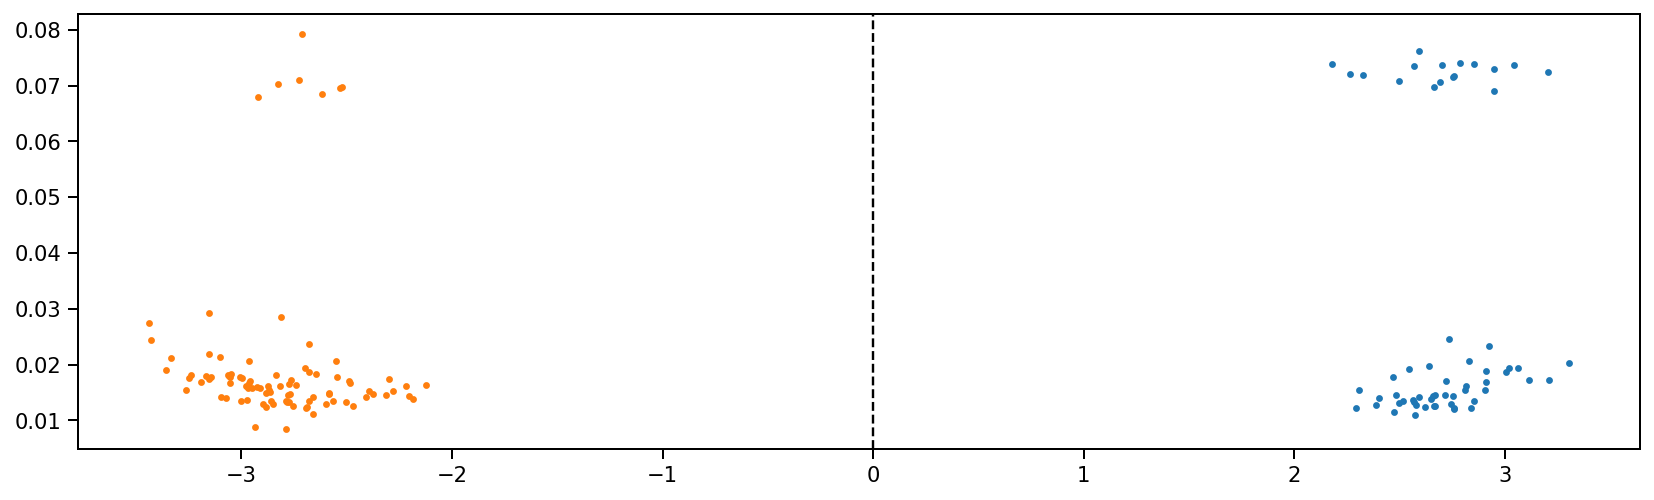

In [34]:
plt.figure(figsize=(14, 4))
mask = df.HA<20
plt.plot(df.HA[mask] , df.stddev_order19[mask], '.')
mask = df.HA>20
plt.plot(df.HA[mask]-24 , df.stddev_order19[mask], '.')
plt.axvline(0.0, linestyle='dashed', color='k')

In [35]:
df['track'] = ''
mask = df.HA<20
df['track'][mask] = 'west'
mask = df.HA>20
df['track'][mask] = 'east'

### Add a column for planet RV

Can we shift the spectrum into the planet rest-frame?  Divide the circumference by the period to get instantaneous tangential velocity.  Assume a circular orbit:

$$ v = \frac{2 \pi a}{P}$$

In [36]:
semi_major_axis = 0.06505 * u.AU

(0.3 * 2 * np.pi * semi_major_axis / (2.0*u.Rjupiter)).to(u.dimensionless_unscaled)

planet_speed_quantity = (2*np.pi*semi_major_axis)/(orbital_period*u.day)

planet_speed_quantity.to(u.km/u.second)

planet_speed = planet_speed_quantity.to(u.km/u.second).value

Convention: Positive RVs are redshifted

In [37]:
df['JD'] = df['DATE-OBS'].apply(lambda x: Time(x).jd)
df['BTJD'] = df.JD -2457000.0

In [38]:
df['RV_planet'] = planet_speed * np.sin(2.0*np.pi*df.normalized_phase)

In [58]:
df['in_transit_text'] = ''
df['preposition'] = ''

In [59]:
mask = df['in_transit_flag']
df['in_transit_text'][mask] = 'in transit'

### Add prepositions to describe phases

It will be helpful to add prepositions:
1. Transit
2. Pre-Transit
3. Post-Transit
4. Baseline
5. Control

In [64]:
threshold = (7.062*u.hour/(4.8101046*u.day)).to(u.dimensionless_unscaled)/2

transit_mask = (df.normalized_phase > (-1*threshold)) & (df.normalized_phase < threshold)
pre_mask = (df.normalized_phase < (-1*threshold)) & (df.normalized_phase > -0.42)
post_mask = (df.normalized_phase > threshold) & (df.normalized_phase < 0.15)
baseline_mask = (df.normalized_phase > 0.4) 
control_mask = (df.normalized_phase > 0.15) & (df.normalized_phase < 0.4) 

In [65]:
df['preposition'][transit_mask] = 'Transit'
df['preposition'][pre_mask] = 'Pre'
df['preposition'][post_mask] = 'Post'
df['preposition'][baseline_mask] = 'Baseline'
df['preposition'][control_mask] = 'Control'

In [66]:
df.preposition.value_counts()

Transit     55
Pre         51
Control     26
Baseline    13
Post         7
Name: preposition, dtype: int64

In [68]:
keep_cols = ['night_number', 'night_of',  'BTJD', 'track','local_hour',  'ENVTEM', 'ENVHUM', 'ENVPRE',
             'ITIME', 'BRVCORR', 'LRVCORR', 'RV_planet',
             'normalized_phase', 'in_transit_flag','in_transit_text',  'preposition', 'campaign']

In [69]:
pd.set_option('display.max_rows', 300)

In [70]:
#df.iloc[0]

In [94]:
df['track'][df.track=='east'] = 'E'
df['track'][df.track=='west'] = 'W'

In [95]:
gb = df[keep_cols].groupby(['night_of', 'track', 'preposition'])

In [96]:
summary_table = gb.aggregate(func={'BTJD':np.mean,
                                   'night_number':np.count_nonzero, 
                   'ITIME':np.mean, 
                   'normalized_phase':np.mean})\
    .sort_index()\
    .round({'normalized_phase':3, 'BTJD':2})

In [97]:
summary_table

,,,BTJD,night_number,ITIME,normalized_phase
night_of,track,preposition,,,,
2020-04-26,E,Pre,1966.78,4,308.85,-0.192
2020-04-27,E,Transit,1967.79,12,308.85,0.018
2020-04-28,E,Control,1968.78,4,308.85,0.225
2020-05-19,W,Pre,1989.95,4,308.85,-0.373
2020-05-20,W,Pre,1990.94,4,308.85,-0.169
2020-05-21,E,Transit,1991.72,14,308.85,-0.006
2020-05-22,W,Control,1992.93,4,308.85,0.246
2020-05-23,W,Baseline,1993.94,4,308.85,0.455
2020-06-12,W,Pre,2013.89,3,308.85,-0.397


## Save to disk

### Save the entire dataframe 
We dropped the bad data, but that's fine!

In [98]:
df.to_feather('../../data/HPF/HAT_P_67_log.feather')

#### Save just the summary table

In [99]:
summary_table = summary_table.reset_index()

In [100]:
file_out = '../../paper/paper1/tables/observation_log.tex'

str_out = '\n'.join(summary_table.to_latex(index=False).split('\n')[4:-3])

with open(file_out, "w+") as f:
        f.writelines(str_out)

/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_70063/1232673245.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  str_out = '\n'.join(summary_table.to_latex(index=False).split('\n')[4:-3])


In [101]:
! tail ../../paper/paper1/tables/observation_log.tex

2022-06-25 &     E &     Transit & 2756.64 &             1 & 308.85 &             0.017 \\
2022-06-30 &     W &        Post & 2761.85 &             1 & 308.85 &             0.101 \\
2022-07-09 &     W &         Pre & 2770.82 &             1 & 308.85 &            -0.035 \\
2022-07-10 &     W &     Control & 2771.81 &             1 & 308.85 &             0.172 \\
2022-07-12 &     W &         Pre & 2773.82 &             3 & 308.85 &            -0.411 \\
2022-07-14 &     W &     Transit & 2775.78 &             1 & 308.85 &            -0.003 \\
2022-07-15 &     W &     Control & 2776.80 &             1 & 308.85 &             0.209 \\
2022-07-19 &     W &        Post & 2780.77 &             1 & 308.85 &             0.034 \\
2022-07-28 &     W &         Pre & 2789.74 &             1 & 308.85 &            -0.101 \\
2022-07-29 &     W &        Post & 2790.78 &             1 & 308.85 &             0.115 \\

#### Spot-check round-tripping works... ✅

In [90]:
#import pyarrow.feather as feather
#feather.read_feather('../../data/HPF/HAT_P_67_log.feather')